In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt


# Add the path to stylegan2-ada-pytorch directory
repo_path = '/Users/oliverlundin/Local Documents/github/facemorph/stylegan2-ada-pytorch'
sys.path.append(repo_path)

import projector


In [2]:
face1_path = 'aligned/align-IMG_0925.jpeg'
face2_path = 'aligned/align-IMG_5267.jpeg'

### Load images and convert to tensors

In [3]:
import torch
from PIL import Image
import numpy as np

face1 = Image.open(face1_path)
face2 = Image.open(face2_path)

# Convert the PIL images to NumPy arrays
face1_array = np.array(face1)
face2_array = np.array(face2)

# Convert NumPy arrays to PyTorch tensors with specified dtype
face1_tensor = torch.tensor(face1_array, dtype=torch.float16)  # Change dtype as needed
face2_tensor = torch.tensor(face2_array, dtype=torch.float16)

# Print the shape of the tensors
print(face1_tensor.shape)
print(face2_tensor.shape)


torch.Size([256, 256, 3])
torch.Size([256, 256, 3])


### Check if we can use GPU, MPS for mac CUDA for nvidia and load the generator

In [4]:
import pickle
import torch.nn.functional as F


# Set device
if(torch.backends.mps.is_available()): # True
    print("MPS is available")
    device = torch.device("mps")


# Load the generator model from the pickle file
with open('ffhq_res256.pkl', 'rb') as f:
	G = pickle.load(f)['G_ema'].to(device) 
    

    

MPS is available


### Change the image tensors to match the generators expected output

Eftersom generatorn är tränad på en viss typ av bilder av en viss storlek måste våra bilder matcha.

In [5]:
face1_tensor = face1_tensor.squeeze()
face1_tensor = face1_tensor.permute(2, 0, 1)
face1_tensor = F.interpolate(face1_tensor.unsqueeze(0), size=(G.img_resolution, G.img_resolution), mode='bilinear', align_corners=False)
face1_tensor = face1_tensor.squeeze(0)

face2_tensor = face2_tensor.squeeze()
face2_tensor = face2_tensor.permute(2, 0, 1)
face2_tensor = F.interpolate(face2_tensor.unsqueeze(0), size=(G.img_resolution, G.img_resolution), mode='bilinear', align_corners=False)
face2_tensor = face2_tensor.squeeze(0)

face1_tensor = face1_tensor.to(device)
face2_tensor = face2_tensor.to(device)

# empty cache
torch.mps.empty_cache()

# Debugging: Print the shapes
print(f"face1_tensor shape: {face1_tensor.shape}")
print(f"face2_tensor shape: {face2_tensor.shape}")
print(f"Expected shape: ({G.img_channels}, {G.img_resolution}, {G.img_resolution})")



face1_tensor shape: torch.Size([3, 256, 256])
face2_tensor shape: torch.Size([3, 256, 256])
Expected shape: (3, 256, 256)


### Project first image into W

Antalet steps är antalet steg den tar i W rymden för att hitta en bild som är så lik bilden vi gett den, fler steg blir alltså bättre.

In [6]:

# Project the image
projected_w_steps1 = projector.project(
    G,
    target=face1_tensor,  # Your target image tensor
    num_steps=10,  # Number of optimization steps
	device = device,
    verbose=True  # Print optimization progress
)


Computing W midpoint and stddev using 10000 samples...
step    1/10: dist 0.50 loss 19594.31
step    2/10: dist 0.57 loss 28332.60
step    3/10: dist 0.48 loss 17734.00
step    4/10: dist 0.41 loss 7414.43
step    5/10: dist 0.38 loss 5368.02
step    6/10: dist 0.36 loss 7915.34
step    7/10: dist 0.37 loss 8621.42
step    8/10: dist 0.38 loss 7144.88
step    9/10: dist 0.39 loss 5832.52
step   10/10: dist 0.39 loss 5693.37


### Project second image into W

In [8]:
projected_w_steps2 = projector.project(
    G,
    target=face2_tensor,  # Your target image tensor
    num_steps=10,  # Number of optimization steps
    device=device,
    verbose=True  # Print optimization progress
)

Computing W midpoint and stddev using 10000 samples...
step    1/10: dist 0.59 loss 33117.84
step    2/10: dist 0.53 loss 32799.57
step    3/10: dist 0.44 loss 20047.97
step    4/10: dist 0.40 loss 7727.67
step    5/10: dist 0.36 loss 6202.29
step    6/10: dist 0.35 loss 9901.87
step    7/10: dist 0.36 loss 11198.62
step    8/10: dist 0.35 loss 9841.15
step    9/10: dist 0.34 loss 8083.51
step   10/10: dist 0.32 loss 7164.92


In [ ]:
projected_w_steps1.shape
projected_w_steps2.shape

In [22]:
# check if the projected_w_steps1 and projected_w_steps2 are exactly the same
(projected_w_steps1 == projected_w_steps2).all()

tensor(False, device='mps:0')

### Create projections

Hitta rätt matriser i projektionen

In [9]:
w1 = projected_w_steps1[-1].unsqueeze(0)
w2 = projected_w_steps2[-1].unsqueeze(0)

### Generate first image

Om man vill generera en "ny" bild utifrån den första bilden kan man köra nedanstående två celler. Men det är egentligen inte nödvändigt och man kan skippa dessa steg

In [10]:
img1 = G.synthesis(w1, noise_mode='const', force_fp32=True)

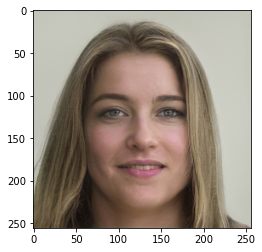

In [11]:
img1 = (img1 + 1) * (255/2)
img1 = img1.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
plt.imshow(img1)

### Generate second image

In [12]:
img2 = G.synthesis(w2, noise_mode='const', force_fp32=True)

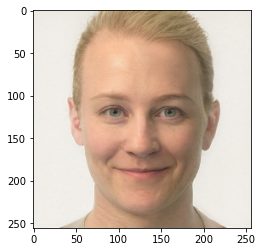

In [13]:
img2 = (img2 + 1) * (255/2)
img2 = img2.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
plt.imshow(img2)

### Interpolate between w1 and w2

Interpolera mellan projektionerna, 10 steg ger 10 bilder

In [14]:
# linear interpolation between w1 and w2
num_interpolations = 10
interpolations = torch.zeros((num_interpolations, w1.shape[1], w1.shape[2]), device=device)
for i in range(num_interpolations):
	interpolations[i] = w1 + (w2 - w1) * i / (num_interpolations - 1)


### Generate the interpolations

Generera 10 bilder utifrån interpolationerna

In [15]:
# Generate the images
interpolated_images = G.synthesis(interpolations, noise_mode='const', force_fp32=True)

Kolla olika bilder utifrån vilket index man stoppar i interpolated_images, 4/5 är någonstanns i mitten och är själva morphen. 0 är bild 1 och 9 är bild 2.

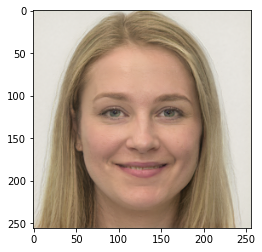

In [16]:
interpolated_images.shape
interpolated_images[5].shape

interpolated_images = (interpolated_images + 1) * (255/2)

interpolated_images = interpolated_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()

# plot the middle image
plt.imshow(interpolated_images[5])

